In [1]:
import sys
sys.path.insert(0, "./../../scripts")

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect

import sim_util as su

def imshowbar(fig,ax,A,showbar=True,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    if showbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(imsh, cax=cax, orientation="vertical")
        return cbar

In [3]:
plt.rcParams["font.sans-serif"] = ["PT Sans","DejaVu Sans"]

# Plot Population Tuning Widths from Fig 3a

In [4]:
nori = 20

sim_μrEs = np.zeros((6,3,nori))
sim_μrIs = np.zeros((6,3,nori))
sim_ΣrEs = np.zeros((6,4,nori))
sim_ΣrIs = np.zeros((6,4,nori))

for c_idx in range(6):
    with open("./../../model_data/best_fit_1s_c_{:d}".format(c_idx)+".pkl","rb") as\
            handle:
        res_dict = pickle.load(handle)

    sim_μrEs[c_idx] = np.mean(res_dict["μrEs"],0)
    sim_μrIs[c_idx] = np.mean(res_dict["μrIs"],0)
    sim_ΣrEs[c_idx] = np.mean(res_dict["ΣrEs"],0)
    sim_ΣrIs[c_idx] = np.mean(res_dict["ΣrIs"],0)

In [5]:
from scipy.interpolate import UnivariateSpline,make_smoothing_spline
from scipy.optimize import root

sim_srMEs = np.zeros((5,2))
sim_srMIs = np.zeros((5,2))
sim_srCEs = np.zeros((5,2))
sim_srCIs = np.zeros((5,2))
dmft_srMEs = np.zeros((5,2))
dmft_srMIs = np.zeros((5,2))
dmft_srCEs = np.zeros((5,2))
dmft_srCIs = np.zeros((5,2))

def periodic_spline(data,n):
    return make_smoothing_spline(np.arange(-n//2,n)/n*180,np.concatenate((data[-n//2:],data)),lam=40)

def calc_HWHM(data,n):
    itp = periodic_spline(data,n)
    half = (itp(0) - itp(90))/2 + itp(90)
    roots = UnivariateSpline(np.linspace(-90,90,181),itp(np.linspace(-90,90,181))-half,s=n//4).roots()
    return 0.5*(roots[1]-roots[0])

for c_idx in range(1,6):
    sim_srMEs[c_idx-1,0] = calc_HWHM(sim_μrEs[c_idx,0,:],nori) / np.sqrt(2*np.log(2))
    sim_srMEs[c_idx-1,1] = calc_HWHM(sim_μrEs[c_idx,1,:],nori) / np.sqrt(2*np.log(2))
    sim_srMIs[c_idx-1,0] = calc_HWHM(sim_μrIs[c_idx,0,:],nori) / np.sqrt(2*np.log(2))
    sim_srMIs[c_idx-1,1] = calc_HWHM(sim_μrIs[c_idx,1,:],nori) / np.sqrt(2*np.log(2))
    sim_srCEs[c_idx-1,0] = calc_HWHM(sim_ΣrEs[c_idx,0,:]+sim_μrEs[c_idx,0,:]**2,nori) / np.sqrt(2*np.log(2))
    sim_srCEs[c_idx-1,1] = calc_HWHM(sim_ΣrEs[c_idx,1,:]+sim_μrEs[c_idx,1,:]**2,nori) / np.sqrt(2*np.log(2))
    sim_srCIs[c_idx-1,0] = calc_HWHM(sim_ΣrIs[c_idx,0,:]+sim_μrIs[c_idx,0,:]**2,nori) / np.sqrt(2*np.log(2))
    sim_srCIs[c_idx-1,1] = calc_HWHM(sim_ΣrIs[c_idx,1,:]+sim_μrIs[c_idx,1,:]**2,nori) / np.sqrt(2*np.log(2))
    
    try:
        with open("./../../model_data/dmft_best_fit_c_{:d}".format(c_idx)+".pkl","rb") as\
                handle:
            res_dict = pickle.load(handle)
        dmft_srMEs[c_idx-1] = res_dict["dmft_res"]["sr"][0::2]
        dmft_srMIs[c_idx-1] = res_dict["dmft_res"]["sr"][1::2]
        dmft_srCEs[c_idx-1] = res_dict["dmft_res"]["sCr"][0::2,0]
        dmft_srCIs[c_idx-1] = res_dict["dmft_res"]["sCr"][1::2,0]
    except:
        dmft_srMEs[c_idx-1] = [np.nan,np.nan]
        dmft_srMIs[c_idx-1] = [np.nan,np.nan]
        dmft_srCEs[c_idx-1] = [np.nan,np.nan]
        dmft_srCIs[c_idx-1] = [np.nan,np.nan]

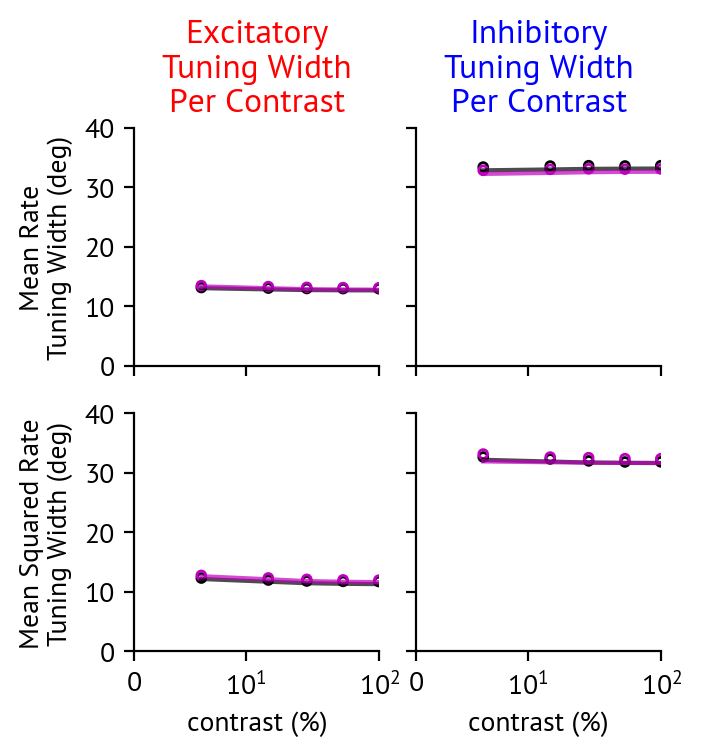

In [6]:
with open("./../../experimental_data/data_contrasts"+".pkl", "rb") as handle:
    cons = pickle.load(handle)[1]
    
fig,axs = plt.subplots(2,2,figsize=(1.7*2,1.7*2),dpi=200,sharex=True,sharey="row")
fig.subplots_adjust(wspace=0.15)

for i in range(2):
    axs[0,0].scatter(cons[1:],sim_srMEs[:,i],edgecolors=["k","m"][i],facecolors="none",marker="o",s=10)
    axs[0,1].scatter(cons[1:],sim_srMIs[:,i],edgecolors=["k","m"][i],facecolors="none",marker="o",s=10)
    axs[1,0].scatter(cons[1:],sim_srCEs[:,i],edgecolors=["k","m"][i],facecolors="none",marker="o",s=10)
    axs[1,1].scatter(cons[1:],sim_srCIs[:,i],edgecolors=["k","m"][i],facecolors="none",marker="o",s=10)
    axs[0,0].plot(cons[1:],dmft_srMEs[:,i],c=["k","m"][i],ls="-",alpha=0.7)
    axs[0,1].plot(cons[1:],dmft_srMIs[:,i],c=["k","m"][i],ls="-",alpha=0.7)
    axs[1,0].plot(cons[1:],dmft_srCEs[:,i],c=["k","m"][i],ls="-",alpha=0.7)
    axs[1,1].plot(cons[1:],dmft_srCIs[:,i],c=["k","m"][i],ls="-",alpha=0.7)

axs[0,0].set_xscale("symlog", linthresh=12)
axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,40)
axs[1,0].set_ylim(0,40)
for i in range(2):
    axs[1,i].set_xlabel("contrast (%)")
    
for ax in axs.flat:
    ax.spines[["right", "top"]].set_visible(False)

axs[0,0].set_ylabel("Mean Rate\nTuning Width (deg)")
axs[1,0].set_ylabel("Mean Squared Rate\nTuning Width (deg)")

axs[0,0].set_title("Excitatory\nTuning Width\nPer Contrast",color="r")
axs[0,1].set_title("Inhibitory\nTuning Width\nPer Contrast",color="b")

fig.savefig("./fig_3a.pdf")

# Plot Response Statistics with Varied Structure and Coupling from Fig 3d

In [7]:
J_osm_diff_means = np.zeros((7,7))
J_vsm_base_means = np.zeros((7,7))
J_vsm_base_stds = np.zeros((7,7))
J_vsm_opto_means = np.zeros((7,7))
J_vsm_opto_stds = np.zeros((7,7))
J_vsm_diff_means = np.zeros((7,7))
J_vsm_diff_stds = np.zeros((7,7))
J_vsm_std_diffs = np.zeros((7,7))
J_vsm_norm_covs = np.zeros((7,7))
J_vsm_base_bals = np.zeros((7,7))
J_vsm_opto_bals = np.zeros((7,7))

def calc_bal(μmuE,μmuI,ΣmuE,ΣmuI,N=10000):
    muEs = np.fmax(μmuE + np.sqrt(ΣmuE)*np.random.randn(N),1e-12)
    muIs = np.fmin(μmuI + np.sqrt(ΣmuI)*np.random.randn(N),-1e-12)
    return np.mean(np.fmax(0,muEs+muIs)/muEs)
            

for sidx in range(7):
    for jidx in range(7):
        with open("./../../model_data/vary_ffwidth_{:d}_J_{:d}".format(sidx,jidx)+".pkl", "rb") as\
                handle:
            res_dict = pickle.load(handle)
        J_osm_diff_means[sidx,jidx] = res_dict["osm_diff_means"]
        J_vsm_base_means[sidx,jidx] = res_dict["vsm_base_means"]
        J_vsm_base_stds[sidx,jidx] = res_dict["vsm_base_stds"]
        J_vsm_opto_means[sidx,jidx] = res_dict["vsm_opto_means"]
        J_vsm_opto_stds[sidx,jidx] = res_dict["vsm_opto_stds"]
        J_vsm_diff_means[sidx,jidx] = res_dict["vsm_diff_means"]
        J_vsm_diff_stds[sidx,jidx] = res_dict["vsm_diff_stds"]
        J_vsm_std_diffs[sidx,jidx] = res_dict["vsm_opto_stds"]-res_dict["vsm_base_stds"]
        J_vsm_norm_covs[sidx,jidx] = res_dict["vsm_norm_covs"]
        J_vsm_base_bals[sidx,jidx] = 0.8*calc_bal(np.mean(res_dict["μhEEs"][:,0,0]),
                                                    np.mean(res_dict["μhEIs"][:,0,0]),
                                                    np.mean(res_dict["ΣhEEs"][:,0,0]),
                                                    np.mean(res_dict["ΣhEIs"][:,0,0])) +\
                                        0.2*calc_bal(np.mean(res_dict["μhIEs"][:,0,0]),
                                                    np.mean(res_dict["μhIIs"][:,0,0]),
                                                    np.mean(res_dict["ΣhIEs"][:,0,0]),
                                                    np.mean(res_dict["ΣhIIs"][:,0,0]))
        J_vsm_opto_bals[sidx,jidx] = 0.8*np.mean(res_dict["balEs"],0)[1,0]+0.2*np.mean(res_dict["balIs"],0)[1,0]

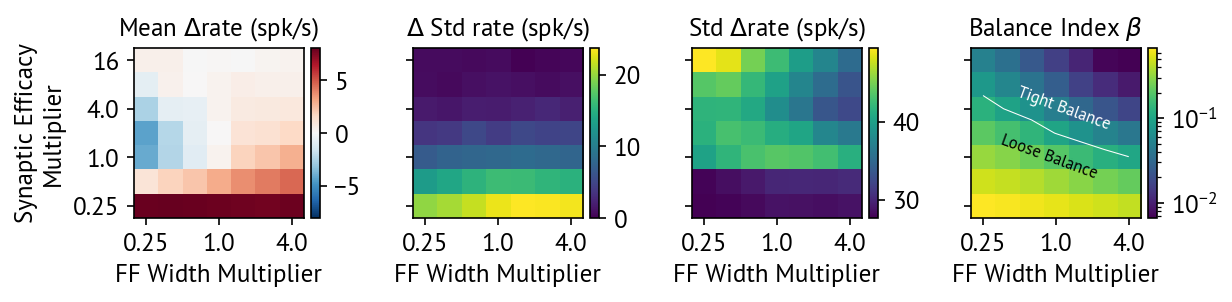

In [8]:
from matplotlib.colors import LogNorm

fig,axs = plt.subplots(1,4,figsize=(2.2*4,1.7*1),dpi=150,sharey="row",sharex="col")
fig.subplots_adjust(wspace=0.5,hspace=0.1)

diff_mean_lim = np.nanmax(np.abs(J_vsm_diff_means[:,:].flatten()))
diff_std_lolim = np.nanmin(J_vsm_diff_stds[:,:].flatten())
diff_std_uplim = np.nanmax(J_vsm_diff_stds[:,:].flatten())
std_diff_lim = np.nanmax(np.abs(J_vsm_std_diffs[:,:].flatten()))
base_bal_lolim = np.nanmin(J_vsm_base_bals[:,:].flatten())
base_bal_uplim = np.nanmax(J_vsm_base_bals[:,:].flatten())

cbar = imshowbar(fig,axs[0],J_vsm_diff_means.T,origin="lower",cmap="RdBu_r",vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1],J_vsm_std_diffs.T,origin="lower",vmin=0,vmax=std_diff_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2],J_vsm_diff_stds.T,origin="lower",vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[3],J_vsm_base_bals.T,origin="lower",norm=LogNorm(vmin=base_bal_lolim, vmax=base_bal_uplim))
cbar.ax.tick_params(labelsize=12)
axs[3].contour(*np.meshgrid(np.arange(7),np.arange(7)),J_vsm_base_bals.T,levels=[0.1],colors="w",linewidths=0.5)
axs[3].text(2.7,2,"Loose Balance",color="k",fontsize=8,ha="center",va="center",rotation=-20)
axs[3].text(3.3,4,"Tight Balance",color="w",fontsize=8,ha="center",va="center",rotation=-20)

axs[0].set_ylabel("Synaptic Efficacy\nMultiplier",fontsize=12)

axs[0].set_yticks(np.arange(0,7,2),["0.25","1.0","4.0","16"],
                  fontsize=12)

for i in range(4):
    axs[i].set_xticks(np.arange(0,7,3),["0.25","1.0","4.0"],
                        fontsize=12)
    axs[i].set_xlabel("FF Width Multiplier",fontsize=12)

axs[0].set_title(r"Mean $\Delta$rate (spk/s)",fontsize=12)
axs[1].set_title(r"$\Delta$ Std rate (spk/s)",fontsize=12)
axs[2].set_title(r"Std $\Delta$rate (spk/s)",fontsize=12)
axs[3].set_title(r"Balance Index $\beta$",fontsize=12)

# fig.tight_layout()
fig.savefig("fig_3d.pdf", bbox_inches="tight")